In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import cufflinks as cf
# Modo offline para rodar os graficos apenas na máquina e não na nuvem
cf.go_offline()

In [155]:
! pip install cufflinks

    100% |████████████████████████████████| 81kB 622kB/s ta 0:00:01
  Running setup.py bdist_wheel for cufflinks ... done
  Stored in directory: /home/clayton/.cache/pip/wheels/7d/ba/8d/38b672c3e40d8bd22dd60b8e6e29965b43f2b4be4d064e44d5
Successfully built cufflinks


In [110]:
df = pd.read_csv('../data/barcode.csv', sep=',')
df.head(10)

,order_id,customer_id,int_itens_comp,product_name,child_category_id,child_category_name,parent_category_id,parent_category_name
0,11260,7927,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
1,4270,7927,5174,Suco Concentrado Uva Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
2,4270,7927,5174,Suco Concentrado Uva Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
3,7471,7927,1036,Café Torrado e Moído a Vácuo 3 Corações Estrad...,303,Café,214,Pai - Mercearia Básica
4,4270,7927,4785,Sabonete em Barra Creme e Flor de Peônia Dove ...,195,Sabonete em Barra,182,Pai - HPC
5,5434,7927,5391,Tomate Pelado em Cubos La Pastina Lata 240g,239,Tomate Pelado,216,Pai- Mercearia Complementar
6,9991,7927,5391,Tomate Pelado em Cubos La Pastina Lata 240g,239,Tomate Pelado,216,Pai- Mercearia Complementar
7,5434,7927,5391,Tomate Pelado em Cubos La Pastina Lata 240g,239,Tomate Pelado,216,Pai- Mercearia Complementar
8,5434,7927,5391,Tomate Pelado La Pastina Lata 240g,239,Tomate Pelado,216,Pai- Mercearia Complementar
9,9991,7927,5391,Tomate Pelado La Pastina Lata 240g,239,Tomate Pelado,216,Pai- Mercearia Complementar


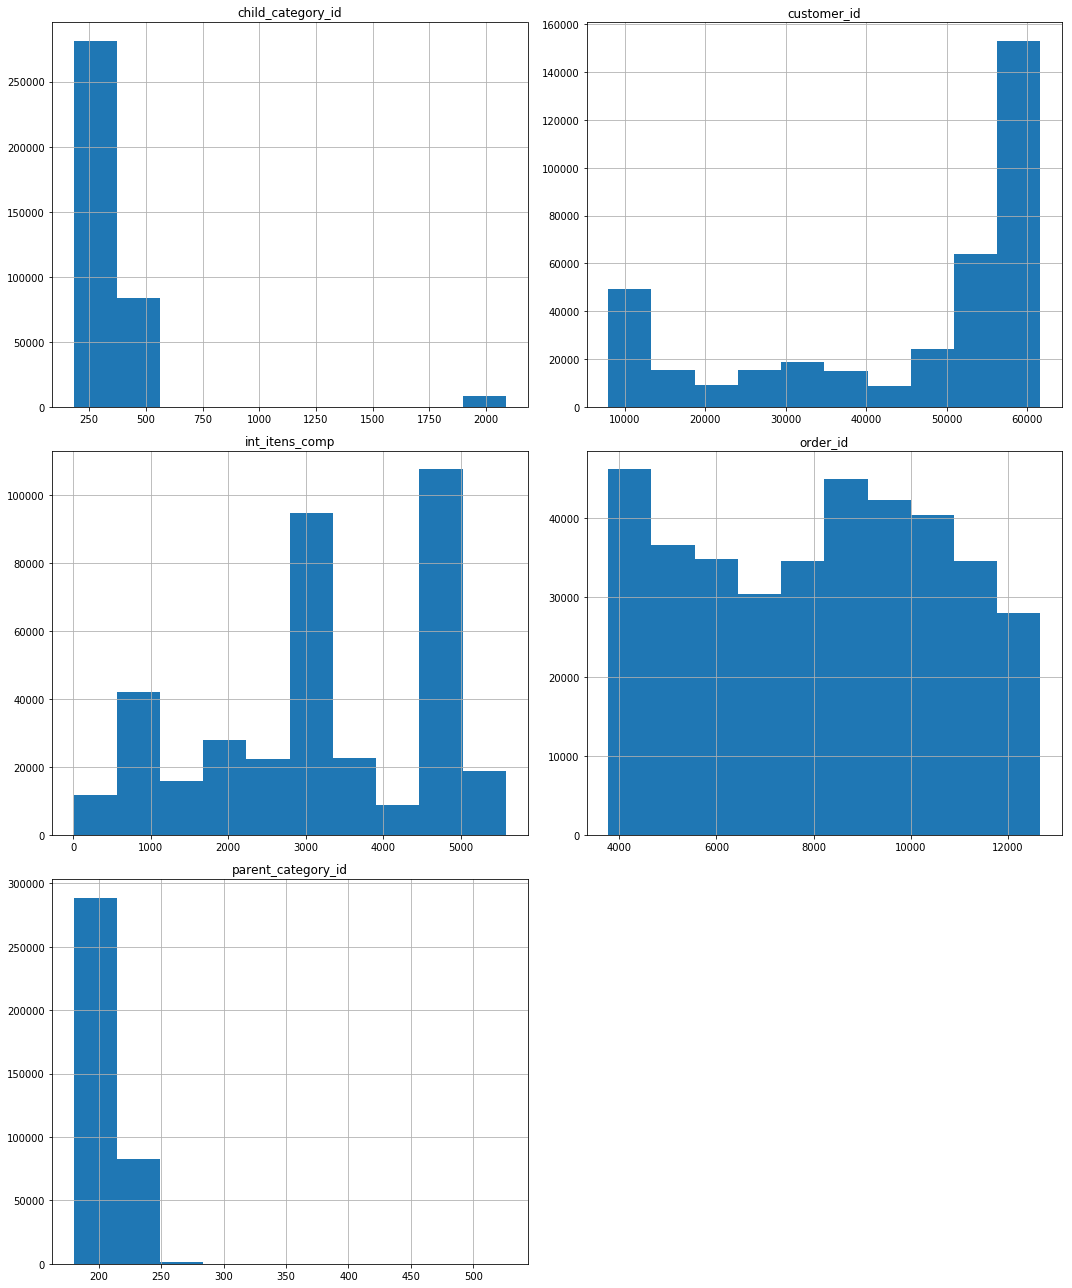

In [112]:
#Verificar distribuição dos dados
df.hist(figsize=(15,18))

plt.tight_layout()
plt.show()

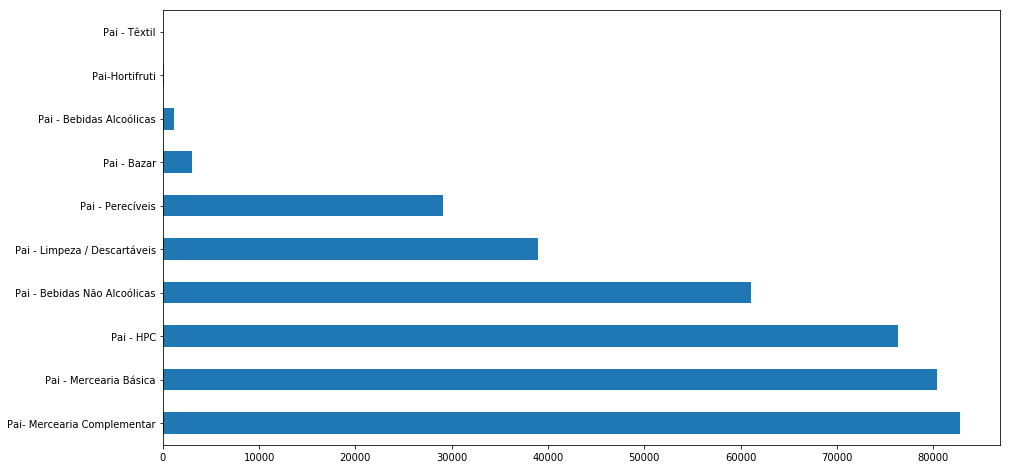

In [113]:
pai = df.parent_category_name.value_counts().plot(kind='barh',figsize=(15,8))
plt.show(pai)

In [115]:
# Quantidade de clusteres por categoria Pai

df.parent_category_name.value_counts()

Pai- Mercearia Complementar     82782
Pai - Mercearia Básica          80435
Pai - HPC                       76372
Pai - Bebidas Não Alcoólicas    61084
Pai - Limpeza / Descartáveis    38999
Pai - Perecíveis                29060
Pai - Bazar                      2987
Pai - Bebidas Alcoólicas         1139
Pai-Hortifruti                    120
Pai - Têxtil                        1
Name: parent_category_name, dtype: int64

In [116]:
# Quantidade de clusteres por categoria Filho

df.child_category_name.value_counts()

Suco                      56091
Sabonete em Barra         45254
Macarrão de Sêmola        32598
Macarrão Instantâneo      18825
Molho de Tomate           12832
                          ...  
Mingau                        1
Lixeira com Pedal             1
Porta-Sabão em Pó             1
Prato Pronto                  1
Revitalizador de Couro        1
Name: child_category_name, Length: 346, dtype: int64

## Filtrando os dados por categorias

    - Podemos observar que temos produtos com apenas uma compra realizada

In [131]:
# quantidade de ítens comprados por name
grup = df.groupby(by='customer_id').product_name.sum()
grup

customer_id
7927     Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...
7952     Guardanapo de Papel Folha Simples Sorella 22cm...
8037     Sorvete Abacaxi Jundiá Pote 2lMacarrão de Sêmo...
8079     Leite UHT Integral Jussara Caixa 1lLeite UHT D...
8086     Refresco em Pó Goiaba Tang Pacote 25gTorrada T...
                               ...                        
61625    Creme Dental Hortelã Colgate Tripla Ação Caixa...
61631    Sabonete em Barra Hidratante Lavanda & Óleos N...
61640    Toalha Umedecida Huggies Supreme Care 19,3cm x...
61643    Sabonete em Barra Glicerinado Flor de Lótus Lu...
61661    Multi Inseticida Aerossol SBP Frasco 450ml Grá...
Name: product_name, Length: 922, dtype: object

In [125]:
# quantidade de ítens comprados por id
df2 = df.groupby(['customer_id']).agg({'product_name': np.size})
df2

,product_name
customer_id,
7927,378
7952,52
8037,41
8079,3
8086,1752
...,...
61625,3154
61631,794
61640,149


In [142]:
# Contagem de produtos por categoria

vendas_categoria = df.groupby(by='child_category_name').product_name.count()
vendas_categoria.head(20)

child_category_name
0101 - CERVEJAS                   34
Abacaxi em Calda                   4
Absorvente Higiênico             831
Achocolatado em Pó               390
Adesivo Instantâneo               47
Adestrador Uso Veterinário         3
Aditivo para Carro                 3
Adoçante                         435
Aguardente                         6
Aipim/Mandioca                     2
Alimento Úmido para Cães         136
Alimento Úmido para Gatos         24
Alvejante                        193
Amaciante de Roupa              1580
Amendoim                         159
Amido                            143
Ampola de Tratamento              37
Aparelho e Lâmina de Barbear    1149
Aparelho e Lâmina de Depilar      87
Aperitivo Bebida                   3
Name: product_name, dtype: int64

In [175]:
prod_menos = vendas_categoria.loc[vendas_categoria.values < 20]
print('Produtos menos vendidos:\n', prod_menos )

Produtos menos vendidos:
 child_category_name
Nata                               9
Polidor de Sapato                  9
Prendedor de Roupa                 9
Cola Multiuso                      9
Queijo Brie                        9
Whisky                             9
Tempero em Pó e Granulado          9
Caneca                             8
Forma para Gelo                    8
Hidratante/Loção Infantil          8
Condicionador Uso Veterinário      8
Prato                              8
Doce de Leite Tablete e Bolinha    8
Patê                               8
Açúcar Mascavo                     8
Mix de Legumes e Vegetais          7
Rodo                               7
Queijo Gouda                       7
Vodka                              7
Aguardente                         6
Porta-Detergente                   6
Feijão Pronto                      6
Funil                              6
Escorredor de Talher               6
Kit Feijoada                       6
Limpa Forno                  

In [178]:
prod_mais = vendas_categoria.loc[vendas_categoria.values > 300]
print('Produtos mais vendidos:\n', prod_mais)

Produtos mais vendidos:
 child_category_name
Suco                            56091
Sabonete em Barra               45254
Macarrão de Sêmola              32598
Macarrão Instantâneo            18825
Molho de Tomate                 12832
                                ...  
Odorizador de Ambiente/Roupa      357
Água de Coco                      354
Leite de Coco                     315
Desodorante para Pés              312
Massa Fresca                      310
Name: product_name, Length: 96, dtype: int64


In [171]:
# Filtrando a categoria com quantidade de vendas > 5
vendas_categoria = vendas_categoria.loc[vendas_categoria.values > 5]
 
# Ordena do maior para o menor
vendas_categoria.sort_values(ascending=False, inplace=True)
vendas_categoria

child_category_name
Suco                    56091
Sabonete em Barra       45254
Macarrão de Sêmola      32598
Macarrão Instantâneo    18825
Molho de Tomate         12832
                        ...  
Kit Feijoada                6
Limpa Forno                 6
Carne Suína                 6
Rum                         6
Limpeza Automotiva          6
Name: product_name, Length: 263, dtype: int64

In [152]:
# Plotando os dados de produtos com suas categorias.
import plotly.offline as py
import plotly.graph_objs as go

In [179]:
# Todos os produtos da categoria filho
trace0 = go.Bar(y=vendas_categoria.values,
               x=vendas_categoria.index,
               marker = {'color': '#00FF2A'},
               orientation='v'
               )

# produtos mais vendidos
trace1 = go.Bar(y=prod_mais.values,
               x=prod_mais.index,
               marker = {'color': '#00FF2A'},
               orientation='v'
               )

# produtos menos vendidos
trace2 = go.Bar(y=prod_menos.values,
               x=prod_menos.index,
               marker = {'color': '#00FF2A'},
               orientation='v'
               )



# Para alterar os plots basta alterar os trace
data = [trace1]


# Criando o Layout
config_layout = go.Layout(title='Vendas por categoria de produtos',
                         xaxis=dict(
                             titlefont=dict(
                                 size=40,
                                 color='lightgrey'),
                         tickangle=75),
                         yaxis={'title':'Quantidade Vendida'})

# Objeto Figura
fig = go.Figure(data=data, layout=config_layout)

# Plotando
py.iplot(fig)

## Divisão por quantidade e clustering

In [117]:
df.head()

,order_id,customer_id,int_itens_comp,product_name,child_category_id,child_category_name,parent_category_id,parent_category_name
0,11260,7927,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
1,4270,7927,5174,Suco Concentrado Uva Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
2,4270,7927,5174,Suco Concentrado Uva Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
3,7471,7927,1036,Café Torrado e Moído a Vácuo 3 Corações Estrad...,303,Café,214,Pai - Mercearia Básica
4,4270,7927,4785,Sabonete em Barra Creme e Flor de Peônia Dove ...,195,Sabonete em Barra,182,Pai - HPC


In [118]:
# quantidade de ítens vendidos por categoria Pai

pai = pd.crosstab(df['product_name'],df['parent_category_name'])
#pai.to_csv('../data/pai.csv')
pai

parent_category_name,Pai - Bazar,Pai - Bebidas Alcoólicas,Pai - Bebidas Não Alcoólicas,Pai - HPC,Pai - Limpeza / Descartáveis,Pai - Mercearia Básica,Pai - Perecíveis,Pai - Têxtil,Pai- Mercearia Complementar,Pai-Hortifruti
product_name,,,,,,,,,,
Abacaxi em Calda Predilecta Lata 400g,0,0,0,0,0,0,0,0,4,0
Absorvente Interno Mini Intimus Caixa 8 Unidades,0,0,0,0,29,0,0,0,0,0
Absorvente Interno Médio Intimus Caixa 8 Unidades,0,0,0,0,29,0,0,0,0,0
Absorvente Interno Médio Intimus Sport Caixa 8 Unidades,0,0,0,0,2,0,0,0,0,0
Absorvente Interno Super Intimus Caixa 8 Unidades,0,0,0,0,29,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
Óleo de Soja Soya Garrafa 900ml,0,0,0,0,0,389,0,0,0,0
Óleo de Soja Tipo 1 Liza Garrafa 900ml,0,0,0,0,0,1408,0,0,0,0
Óleo para Bebê Johnson's Baby Amêndoas Frasco 200ml,0,0,0,5,0,0,0,0,0,0


In [87]:
# função para saber todos os ítens comprados por um cliente

def customer_compra(id_client):
    #self.id_client = id_client
    result = df[df["customer_id"] == id_client]
    return result

customer_compra(7927)

,order_id,customer_id,int_itens_comp,product_name,child_category_id,child_category_name,parent_category_id,parent_category_name
0,11260,7927,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
1,4270,7927,5174,Suco Concentrado Uva Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
2,4270,7927,5174,Suco Concentrado Uva Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
3,7471,7927,1036,Café Torrado e Moído a Vácuo 3 Corações Estrad...,303,Café,214,Pai - Mercearia Básica
4,4270,7927,4785,Sabonete em Barra Creme e Flor de Peônia Dove ...,195,Sabonete em Barra,182,Pai - HPC
...,...,...,...,...,...,...,...,...
373,7471,7927,2776,Iogurte Grego Banana Calda Chocolate Vigor Pot...,242,Iogurte,191,Pai - Perecíveis
374,7471,7927,2776,Iogurte Grego Calda Blueberry Vigor Pote 100g,242,Iogurte,191,Pai - Perecíveis
375,9991,7927,1039,Café Torrado e Moído Tradicional Caboclo Pacot...,303,Café,214,Pai - Mercearia Básica
376,7471,7927,2776,Iogurte Grego Flocos de Caramelo Vigor Loucos ...,242,Iogurte,191,Pai - Perecíveis


In [89]:
# função para saber informações sobre o Produto

def product_info(id_iten):
    result = df[df["int_itens_comp"] == id_iten]
    return result

product_info(2313)

,order_id,customer_id,int_itens_comp,product_name,child_category_id,child_category_name,parent_category_id,parent_category_name
0,11260,7927,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
147,9991,7927,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
262,4270,7927,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
1287,9576,8086,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
1288,9576,8086,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
...,...,...,...,...,...,...,...,...
372390,9769,61640,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
372393,9769,61640,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
372395,9769,61640,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica
372396,9769,61640,2313,Farinha de Trigo Tipo 1 Famiglia Venturelli Pa...,482,Farinha de Trigo,214,Pai - Mercearia Básica


In [86]:
# função para saber todos os ítens por categoria Pai

def customer_compra(id_compra):
    result = df[df["parent_category_id"] == id_compra]
    return result

customer_compra(180)

,order_id,customer_id,int_itens_comp,product_name,child_category_id,child_category_name,parent_category_id,parent_category_name
1,4270,7927,5174,Suco Concentrado Uva Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
2,4270,7927,5174,Suco Concentrado Uva Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
13,5434,7927,5174,Suco Concentrado Goiaba Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
29,4270,7927,5174,Suco Concentrado Goiaba Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
45,5434,7927,5174,Suco Concentrado Uva Dafruta Garrafa 500ml,181,Suco,180,Pai - Bebidas Não Alcoólicas
...,...,...,...,...,...,...,...,...
372868,6610,61643,4680,Refrigerante Limão Sprite Garrafa 2l,394,Refrigerante,180,Pai - Bebidas Não Alcoólicas
372871,4432,61643,4581,Refresco em Pó Laranja e Limão Tang Nosso Mix ...,181,Suco,180,Pai - Bebidas Não Alcoólicas
372878,4432,61643,4581,Refresco em Pó Abacaxi Tang Pacote 25g,181,Suco,180,Pai - Bebidas Não Alcoólicas
372888,4432,61643,4581,Refresco em Pó Abacaxi Tang Pacote 25g,181,Suco,180,Pai - Bebidas Não Alcoólicas


In [23]:
# Criando uma tabela com usuario, id da categoria Pai e a quantidade de compras por usuário
data = pd.melt(df.set_index('customer_id')['parent_category_id'].apply(pd.Series).reset_index(), id_vars=['customer_id'],
             value_name='parent_category_id') \
    .dropna().drop(['variable'], axis=1) \
    .groupby(['customer_id', 'parent_category_id']) \
    .agg({'parent_category_id': 'count'}) \
    .rename(columns={'parent_category_id': 'purchase_count'}) \
    .reset_index() \
    .rename(columns={'parent_category_id': 'productId'})
data['productId'] = data['productId'].astype(np.int64)

In [24]:
data

,customer_id,productId,purchase_count
0,7927,180,15
1,7927,182,76
2,7927,185,42
3,7927,191,108
4,7927,211,1
...,...,...,...
5142,61643,211,1
5143,61643,214,70
5144,61643,216,21
5145,61661,185,72


In [30]:
df_matrix = pd.pivot_table(data, values='purchase_count', index='customer_id', columns='productId')
df_matrix

productId,180,182,185,191,211,214,216,275,282,526
customer_id,,,,,,,,,,
7927,15.0,76.0,42.0,108.0,1.0,85.0,51.0,NaN,NaN,NaN
7952,6.0,NaN,13.0,1.0,4.0,19.0,9.0,NaN,NaN,NaN
8037,NaN,NaN,2.0,8.0,3.0,22.0,6.0,NaN,NaN,NaN
8079,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
8086,841.0,175.0,139.0,54.0,12.0,275.0,256.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
61625,555.0,561.0,574.0,333.0,10.0,343.0,776.0,1.0,1.0,NaN
61631,NaN,452.0,33.0,NaN,8.0,213.0,88.0,NaN,NaN,NaN
61640,61.0,16.0,8.0,NaN,NaN,24.0,40.0,NaN,NaN,NaN


In [44]:
# Substituindo NaN por 0

df_matrix[np.isnan(df_matrix)] = 0
df_matrix = pd.DataFrame(df_matrix)
df_matrix

productId,180,182,185,191,211,214,216,275,282,526
customer_id,,,,,,,,,,
7927,15.0,76.0,42.0,108.0,1.0,85.0,51.0,0.0,0.0,0.0
7952,6.0,0.0,13.0,1.0,4.0,19.0,9.0,0.0,0.0,0.0
8037,0.0,0.0,2.0,8.0,3.0,22.0,6.0,0.0,0.0,0.0
8079,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
8086,841.0,175.0,139.0,54.0,12.0,275.0,256.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
61625,555.0,561.0,574.0,333.0,10.0,343.0,776.0,1.0,1.0,0.0
61631,0.0,452.0,33.0,0.0,8.0,213.0,88.0,0.0,0.0,0.0
61640,61.0,16.0,8.0,0.0,0.0,24.0,40.0,0.0,0.0,0.0


In [51]:
# Normalizando o dataset

df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
df_matrix_norm

productId,180,182,185,191,211,214,216,275,282,526
customer_id,,,,,,,,,,
7927,0.011538,0.082073,0.073171,0.143617,0.017241,0.096263,0.045133,0.000000,0.000000,0.0
7952,0.004615,0.000000,0.022648,0.001330,0.068966,0.021518,0.007965,0.000000,0.000000,0.0
8037,0.000000,0.000000,0.003484,0.010638,0.051724,0.024915,0.005310,0.000000,0.000000,0.0
8079,0.000000,0.000000,0.000000,0.000000,0.000000,0.003398,0.000000,0.000000,0.000000,0.0
8086,0.646923,0.188985,0.242160,0.071809,0.206897,0.311438,0.226549,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
61625,0.426923,0.605832,1.000000,0.442819,0.172414,0.388448,0.686726,0.028571,0.009709,0.0
61631,0.000000,0.488121,0.057491,0.000000,0.137931,0.241223,0.077876,0.000000,0.000000,0.0
61640,0.046923,0.017279,0.013937,0.000000,0.000000,0.027180,0.035398,0.000000,0.000000,0.0


In [57]:
# Maxhine Learning
X = df_matrix.iloc[:,:].values
X

array([[ 15.,  76.,  42., ...,   0.,   0.,   0.],
       [  6.,   0.,  13., ...,   0.,   0.,   0.],
       [  0.,   0.,   2., ...,   0.,   0.,   0.],
       ...,
       [ 61.,  16.,   8., ...,   0.,   0.,   0.],
       [ 44., 272.,  30., ...,   0.,   0.,   0.],
       [  0.,   0.,  72., ...,   0.,   0.,   0.]])

In [61]:
kmeans = KMeans(n_clusters = 8, init = 'random')
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [62]:
kmeans.cluster_centers_

array([[ 6.11441441e+01,  2.10747748e+02,  9.79639640e+01,
         6.51711712e+01,  7.26126126e+00,  1.81495495e+02,
         1.83594595e+02,  2.16216216e-01,  2.36936937e+00,
         1.95156391e-18],
       [ 9.47750000e+02,  5.43250000e+02,  2.66375000e+02,
         2.88500000e+02,  1.52500000e+01,  4.85875000e+02,
         6.42125000e+02,  7.50000000e-01,  2.12500000e+00,
         0.00000000e+00],
       [ 1.03163065e+01,  1.36836935e+01,  8.11787819e+00,
         7.64833006e+00,  7.66208251e-01,  1.74970530e+01,
         1.91846758e+01,  3.53634578e-02,  4.04715128e-01,
         9.10729825e-18],
       [ 3.32411765e+01,  7.12588235e+01,  4.53352941e+01,
         3.53588235e+01,  3.74705882e+00,  9.73000000e+01,
         9.15470588e+01,  2.94117647e-01,  1.52352941e+00,
        -1.30104261e-18],
       [ 6.11464286e+02,  2.62357143e+02,  1.22321429e+02,
         6.15000000e+01,  7.32142857e+00,  2.50928571e+02,
         2.55250000e+02,  5.55111512e-17,  8.92857143e-01,
         3.

In [63]:
distance = kmeans.fit_transform(X)
distance

array([[ 348.87734626,   89.31086376,  142.89912276, ..., 1345.07331481,
         606.34853871,  550.3661559 ],
       [ 404.95346051,  148.72033063,   20.42297108, ..., 1452.40738852,
         723.53194152,  659.96538209],
       [ 410.57985505,  151.87874416,   23.86117013, ..., 1457.21545726,
         726.2571104 ,  662.72672012],
       ...,
       [ 344.88720362,  119.54067817,   54.76612563, ..., 1397.32597803,
         688.44911969,  624.59963621],
       [ 347.36157138,  217.37699939,  265.71338965, ..., 1297.04223353,
         525.15326372,  567.97808545],
       [ 417.07882253,  165.37387064,   73.14423092, ..., 1456.23906767,
         726.5731831 ,  668.06599391]])

In [69]:
labels = kmeans.labels_
labels

array([1, 2, 2, 2, 4, 3, 2, 2, 3, 1, 2, 2, 3, 2, 2, 1, 3, 3, 2, 2, 2, 3,
       1, 2, 2, 2, 3, 1, 1, 1, 3, 2, 2, 2, 3, 1, 2, 1, 1, 3, 2, 2, 1, 2,
       2, 3, 2, 3, 1, 3, 2, 7, 2, 3, 1, 2, 1, 1, 2, 2, 3, 2, 2, 3, 1, 1,
       2, 2, 2, 2, 0, 2, 3, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 6, 1, 2, 2,
       0, 1, 2, 2, 2, 1, 2, 2, 7, 1, 0, 1, 1, 2, 2, 2, 1, 2, 7, 2, 2, 2,
       1, 2, 3, 2, 2, 2, 1, 2, 1, 6, 2, 2, 2, 0, 2, 2, 2, 2, 3, 1, 3, 3,
       0, 2, 7, 2, 2, 2, 2, 2, 1, 2, 1, 3, 2, 3, 2, 2, 1, 2, 2, 2, 1, 2,
       3, 2, 1, 2, 2, 2, 2, 3, 2, 1, 2, 2, 5, 2, 1, 3, 2, 3, 2, 1, 2, 1,
       1, 2, 2, 2, 6, 2, 1, 2, 2, 2, 2, 2, 6, 1, 0, 2, 3, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 5, 2, 2, 4, 2, 2, 2,
       3, 2, 0, 2, 3, 3, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 3, 1, 2, 6, 0, 2,
       2, 2, 1, 1, 4, 3, 0, 2, 4, 1, 2, 0, 3, 2, 3, 2, 2, 3, 3, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 3, 1, 1, 2, 3, 2, 2, 2, 7, 2,
       2, 1, 2, 2, 0, 2, 6, 2, 3, 1, 2, 2, 1, 1, 5,

In [72]:
# Predizendo o cluster

data = [[15.0,76.0,42.0,108.0,1.0,85.0,51.0,0.0,0.0,0.0],[555.0,561.0,574.0,333.0,10.0,343.0,776.0,1.0,1.0,0.0],[0.000000,0.000000,0.003484,0.010638,0.051724,0.024915,0.005310,0.000000,0.000000,0.0]]
kmeans.predict(data)

array([1, 5, 2], dtype=int32)

In [75]:
# O fit_predict retorna os rotulos dos clusteres
df_matrix["Cluster"] = kmeans.fit_predict(X)
df_matrix

productId,180,182,185,191,211,214,216,275,282,526,Cluster
customer_id,,,,,,,,,,,
7927,15.0,76.0,42.0,108.0,1.0,85.0,51.0,0.0,0.0,0.0,6
7952,6.0,0.0,13.0,1.0,4.0,19.0,9.0,0.0,0.0,0.0,1
8037,0.0,0.0,2.0,8.0,3.0,22.0,6.0,0.0,0.0,0.0,1
8079,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1
8086,841.0,175.0,139.0,54.0,12.0,275.0,256.0,0.0,0.0,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...
61625,555.0,561.0,574.0,333.0,10.0,343.0,776.0,1.0,1.0,0.0,0
61631,0.0,452.0,33.0,0.0,8.0,213.0,88.0,0.0,0.0,0.0,5
61640,61.0,16.0,8.0,0.0,0.0,24.0,40.0,0.0,0.0,0.0,1


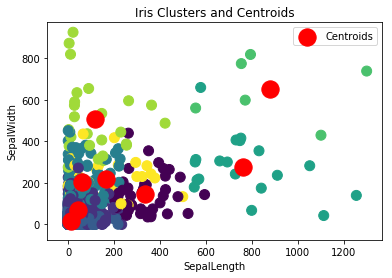

In [65]:
plt.scatter(X[:, 0], X[:,1], s = 100, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'red',label = 'Centroids')
plt.title('Iris Clusters and Centroids')
plt.xlabel('SepalLength')
plt.ylabel('SepalWidth')
plt.legend()

plt.show()